# BB84 Simplified QKD protocol 

For import we will just need the standard *Qiskit* package with some visualization possibilities and some (classical) package for random numbers generation.

In [96]:
import qiskit
from qiskit.visualization import plot_histogram
import random

Set the number of runs: in generating the key, we will disregard roughly half of the generated outcomes, so for example if you want a key of length $\sim 500$ bits, use $\sim 1000$ runs.

We also pick the simulator and prepare registers for storing outcomes: <code>outA</code> for Alice and <code>outB</code> for Bob (we keep them formally separate in order to show that they are spatially separated).

*Note: Naturally, the program would be simpler if we would just use joint register for both Alice and Bob, but for instructive purposes we leave them separate. Suppose Alice is here on Earth, while Bob is in a galaxy far, far away. They have no form of quick communication. They can do so only at a later point.*

In [97]:
RUNS = 1024
simulator = qiskit.Aer.get_backend('qasm_simulator')

outA = []
outB = []

The algorithm is now following.

For each run do the following:
1. Alice chooses randomly the sent bit $x=0$ or $x=1$ and prepares initial state either $|0\rangle$ or $|1\rangle$.
2. Alice chooses randomly whether to leave the bit intact ($a=0$) or whether to change it by Hadamard transformation ($a=1$).
3. Based on her choices she prepared one of the states $\{|0\rangle,|1\rangle,|+\rangle,|-\rangle\}$, which she sends to Bob (over large distace to Galaxy far far away...).
4. Bob receives the sent state and chooses randomly whether to leave it as is ($b=0$) or whether to apply Hadamard transformation on it ($b=1$) without being aware of Alice's choice.
5. Finally Bob performs a measurement and obtains bit $y$.

### Programming task 1:

In [41]:
for i in range(RUNS):
    # In each run we create separate circuit corresponding to choices a and b of Alice and Bob
    circuit = qiskit.QuantumCircuit(1, 1)
    
    """
    Write a code below that determines what Alice does with the circuit,
    following steps 1-3. Store the choices of Alice in outA, where each
    element of the array will be a pair of values (a,x) in corresponding
    step.
    """
    initial_state = [1, 0]
    x = random.randint(0, 1)
    if(x):
        initial_state = [0, 1]
        
    circuit.initialize(initial_state ,0)
    
    
    a = random.randint(0, 1)
    if(a):
        circuit.h(0)
    
    outA.append((a, x))
    # Prepared state is sent to Bob
    # Barrier is just a visual aid to show Alice's and Bob's separation
    circuit.barrier()
    
    """
    Write a code below that determines what Bob does with the circuit,
    following steps 4 and 5. Store the choices of Bob in outB, where each
    element of the array will be a pair of values (b,y) in corresponding
    step. After defining the circuit let it run only once, i.e. in execute
    function use shots=1.
    """
    b = random.randint(0, 1)
    if(b):
        circuit.h(0)
        
    circuit.measure(0, 0)
    job = qiskit.execute(circuit, simulator, shots=1)
    counts = job.result().get_counts()
    y = int(next(iter(counts)))
    
    outB.append((b, y))

Now Alice and Bob by an authenticated channel compare only their choices $a$ and $b$ in respective runs and based on this information keep only those bits $x$ and $y$ for which $a=b$.

In [42]:
# Publicly shared information of ALice and Bob
publicA = [x[0] for x in outA]
publicB = [y[0] for y in outB]

# Locally stored keys obtained from public information
keyA = []
keyB = []

for i in range(RUNS):
    if publicA[i] == publicB[i]:
        keyA += [outA[i][1]]
        keyB += [outB[i][1]]

Alice and Bob have their separate keys <code>keyA</code> and <code>keyB</code>. Let us check whether these are the same:

In [43]:
keyA == keyB

True

The length of the key is

In [44]:
print(len(keyA))

516


Let us have a look at the statistic a bit.

In [45]:
counts = {}
out = [(outA[i][0], outB[i][0], outA[i][1], outB[i][1]) for i in range(RUNS)]
for x in out:
    counts[x] = counts.get(x, 0) + 1

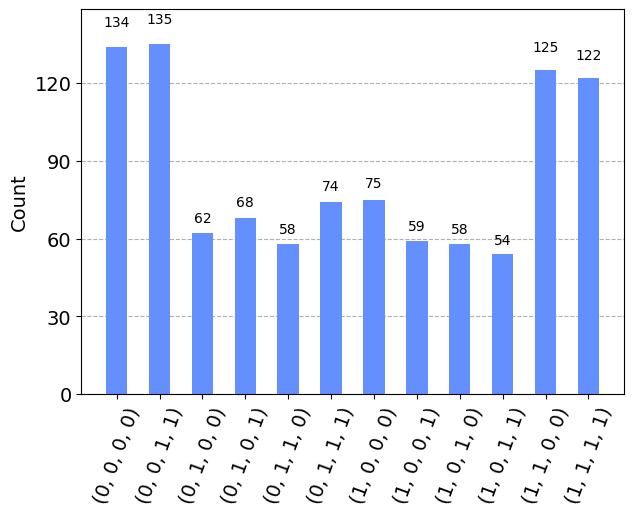

In [46]:
plot_histogram(counts)

If we look at the cases where Alice's and Bob's bases coincide:

In [47]:
eq_out = {(0, 0): 0, (0, 1): 0, (1, 0): 0, (1, 1): 0}
for x in counts:
    if x[0] == x[1]:
        eq_out[x[2:]] += counts[x]
print(eq_out)

{(0, 0): 259, (0, 1): 0, (1, 0): 0, (1, 1): 257}


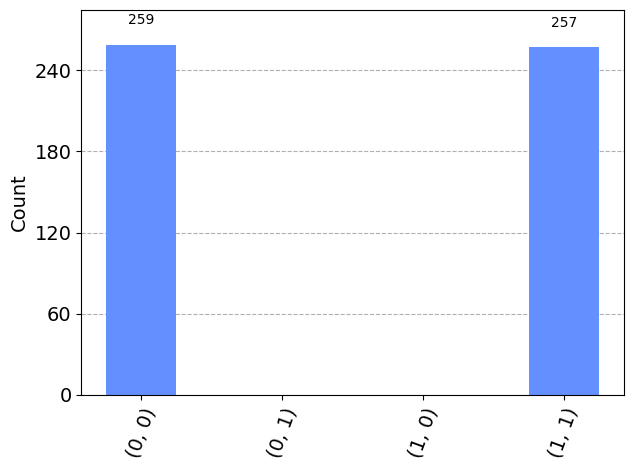

In [48]:
plot_histogram(eq_out)

### *Question:*

Based on previous results decide whether Alice and Bob are in possession of a key that is:
- random
- shared between Alice and Bob
- known only to them

## What about Eve?

If there is an eavesdropper Eve, what she can do is to do the same thing that Bob would do - choose a basis using a bit $e$ and measure. Whatever she measures is also her best guess on what state Alice sent, so she sends it to Bob.

In [98]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

outA = []
outB = []
outE = []

###  Programming task 2:

In [99]:
for i in range(RUNS):
    # In each run we create separate circuit corresponding to choices a and b of Alice and Bob
    # Now we have to classical registers, one for Bob's measurement and the second one for Eve's
    circuit = qiskit.QuantumCircuit(1,2)
    
    """
    Copy below the actions of Alice from program above.
    """
    initial_state = [1, 0]
    x = random.randint(0, 1)
    if(x):
        initial_state = [0, 1]
        
    circuit.initialize(initial_state ,0)
    
    
    a = random.randint(0, 1)
    if(a):
        circuit.h(0)
    
    outA.append((a, x))
    
    
    # Prepared state is sent to Bob but first intercepted by Eve
    # Barrier is just a visual aid to show Alice's and Bob's separation
    circuit.barrier()
    
    """
    Write a code below that determines what Eve does with the circuit:
    choosing a basis in which to measure and based on her measurement
    decide the state to send forward. Store the choices of Eve in outE,
    where each element of the array will be a pair of values (e,z) of
    Eves basis choice e and measurement outcome z, in corresponding
    step.
    
    Note 1: Remember that after Eve measures 0 the state is in |0> and
    if she measures 1 the state is in |1> afterwards.
    
    Note 2: Since the measurement outcome cannot be determined at this
    point, the execution of storing the data (e,z) needs to be done
    not here, but at the end of the program after the execution command,
    as is written below.
    """
    
    e = random.randint(0, 1)
    if (e):
        circuit.h(0)

    circuit.measure(0, 1)
    
    
    # The state is now sent to Bob
    circuit.barrier()
    
    """
    Copy below the actions of Bob from program above.
    """
    b = random.randint(0, 1)
    if(b):
        circuit.h(0)
        
    circuit.measure(0, 0)
    job = qiskit.execute(circuit, simulator, shots=1)
    counts = job.result().get_counts()
    y = int(next(iter(counts))[0])
    
    outB.append((b, y))
    
    # Eve stores her choice and outcome z
    z = int(next(iter(counts))[1])
    outE += [(e, z)]
    

Let us just count the results for Alice and Bob only.

In [100]:
counts_wE = {} # counts with Eve present
out_wE = [(outA[i][0], outB[i][0], outA[i][1], outB[i][1]) for i in range(RUNS)]
for x in out_wE:
    counts_wE[x] = counts_wE.get(x, 0) + 1

What do we observe in case $a=b$?

In [101]:
eq_out_wE = {(0, 0): 0, (0, 1): 0, (1, 0): 0, (1, 1): 0}
for x in counts_wE:
    if x[0] == x[1]:
        eq_out_wE[x[2:]] += counts_wE[x]
print(eq_out_wE)

{(0, 0): 206, (0, 1): 70, (1, 0): 67, (1, 1): 185}


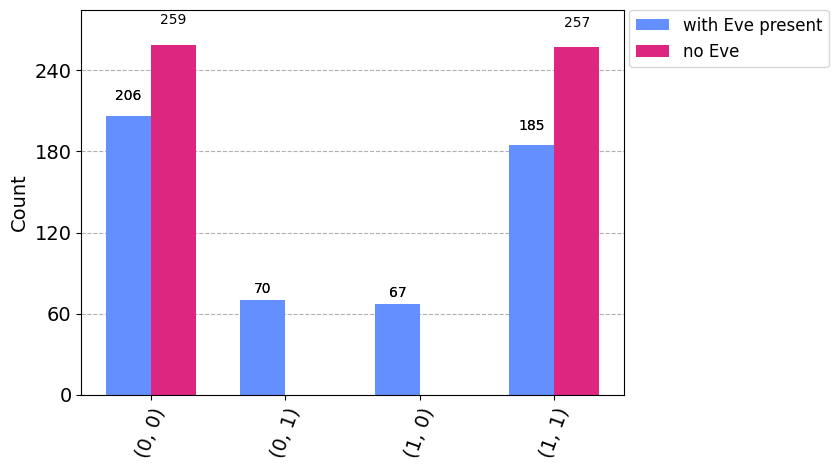

In [102]:
plot_histogram([eq_out_wE, eq_out], legend=["with Eve present", "no Eve"])

Let us formally continue in the process of key establishment, when Alice and Bob publicly, through an authenticated channel compare their choices of the bases. If Eve can perfectly eavesdrop on this channel, she can also try to reconstruct key on her side by selecting only the bits where Alice's and Bob's choices of basis were the same.

In [103]:
# Publicly shared information of ALice and Bob
publicA = [x[0] for x in outA]
publicB = [y[0] for y in outB]

# Locally stored keys obtained from public information
keyA = []
keyB = []
keyE = []

for i in range(RUNS):
    if publicA[i] == publicB[i]:
        keyA += [outA[i][1]]
        keyB += [outB[i][1]]
        keyE += [outE[i][1]]

We can now construct a correlator function which will tell us in how many % compared keys are the same.

In [104]:
def correlation(x, y):
    size = len(x)
    count = 0
    for j in range(size):
        if x[j] == y[j]:
            count += 1
    return count / size

Comparing keys of Alice and Bob:

In [105]:
print("Alice's and Bob's keys agree in {:.1f}% bits".format(100*correlation(keyA, keyB)))

Alice's and Bob's keys agree in 74.1% bits


Comparing Alice's or Bob's keys with Eve's key:

In [106]:
print("Alice's and Eve's keys agree in {:.1f}% bits".format(100*correlation(keyA, keyE)))
print("Bob's and Eve's keys agree in {:.1f}% bits".format(100*correlation(keyB, keyE)))

Alice's and Eve's keys agree in 62.1% bits
Bob's and Eve's keys agree in 73.3% bits
